In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip drive/MyDrive/Deepfake-Detection/dataset.zip > /dev/null

In [1]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
# dataset loading 
input_shape = (128, 128, 3)
data_dir = 'dataset'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]

print('real data: ',len(real_data))
print('fake data: ', len(fake_data))
print('tatal size: ', (len(real_data)+len(fake_data)))

X = []
Y = []
for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y

#Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

#Reshape
X = X.reshape(-1, 128, 128, 3)

#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=5)

real data:  22897
fake data:  21431
tatal size:  44328


In [7]:
# creating model 
googleNet_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
googleNet_model.trainable = True
model = Sequential()
model.add(googleNet_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.75))
model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.75))
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536)              0         
_________________________________________________________________
batch_normalization_408 (Bat (None, 1536)              6144      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               786944    
_________________________________________________________________
batch_normalization_409 (Bat (None, 512)              

In [8]:
#model training 
EPOCHS = 100
BATCH_SIZE = 128
early_stopping_patience = 10
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stopping_patience, restore_best_weights=True)
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    validation_data=(X_val, Y_val), verbose=1,callbacks=[early_stopping])

Epoch 1/100
312/312 [==============================] - 137s 382ms/step - loss: 0.6558 - accuracy: 0.7368 - val_loss: 0.5482 - val_accuracy: 0.7036
Epoch 2/100
312/312 [==============================] - 116s 371ms/step - loss: 0.2775 - accuracy: 0.9013 - val_loss: 0.7998 - val_accuracy: 0.8728
Epoch 3/100
312/312 [==============================] - 116s 371ms/step - loss: 0.1595 - accuracy: 0.9396 - val_loss: 0.2968 - val_accuracy: 0.8753
Epoch 4/100
312/312 [==============================] - 116s 371ms/step - loss: 0.2634 - accuracy: 0.9151 - val_loss: 0.3223 - val_accuracy: 0.8725
Epoch 5/100
312/312 [==============================] - 116s 371ms/step - loss: 0.1546 - accuracy: 0.9448 - val_loss: 3.5630 - val_accuracy: 0.7435
Epoch 6/100
312/312 [==============================] - 116s 371ms/step - loss: 0.1564 - accuracy: 0.9476 - val_loss: 0.2742 - val_accuracy: 0.9538
Epoch 7/100
312/312 [==============================] - 116s 371ms/step - loss: 0.1002 - accuracy: 0.9665 - val_loss: 1

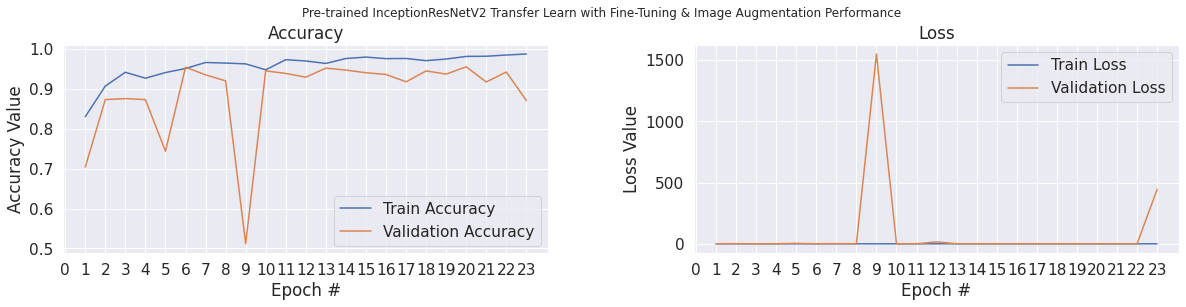

In [9]:
# plotting Accuracy and Loss
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained InceptionResNetV2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,early_stopping.stopped_epoch+2))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, early_stopping.stopped_epoch+2, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, early_stopping.stopped_epoch+2, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


True positive =  20933
False positive =  498
False negative =  470
True negative =  22427




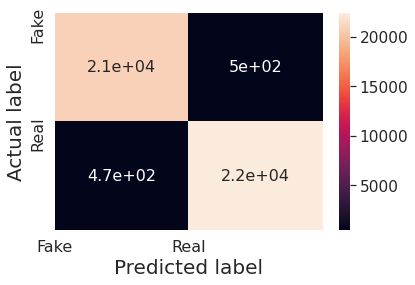

In [10]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    
print_confusion_matrix(Y_val_org, model.predict_classes(X))

In [12]:
# saving model for local use.
model.save('drive/MyDrive/Deepfake-Detection/deepfake-detection-model-v3(lr_.001).h5')

In [ ]:
# to keep colab alive
while True:pass